# LLaMA 3 8B Text Classification With QLoRA 

In [1]:
import pandas as pd
import numpy as np
import torch
import json
import wandb
from transformers import BitsAndBytesConfig, AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, DataCollatorWithPadding, Trainer
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, classification_report
from datasets import Dataset, DatasetDict
import datetime
import torch.nn.functional as F

In [2]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

run = wandb.init(
    project='wz_experimental',
    config={"model_name": "Meta-Llama-3-8B"}
)

wandb: Currently logged in as: kawishbit (kawishbit-org). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kawis\_netrc


In [3]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

In [4]:
train = pd.read_csv('../datasets/quotes/quotes_train.csv')
test = pd.read_csv('../datasets/quotes/quotes_test.csv')
validation = train.sample(2091, random_state=42)
train = train.drop(validation.index)

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validation = validation.sample(frac=1).reset_index(drop=True)

In [5]:
train.head()

,text,label,level
0,ignorance as a deliberate choice can be used ...,4,C1
1,intolerance is a form of divided consciousness...,4,C1
2,all of us have moments in our lives that test ...,0,A1
3,if you have a problem with the moon in the sky...,0,A1
4,does anyone ever cry and you know youve been h...,0,A1


In [6]:
test.head()

,text,label,level
0,posture power when interviewing for a job rem...,4,C1
1,a new heaven is the emergence of a transformed...,3,B2
2,god has given you the same brain so use your ...,0,A1
3,with thought patience and discrimination bo...,3,B2
4,and if there is one last thing i would have yo...,0,A1


In [7]:
validation.head()

,text,label,level
0,looking back i wonder if mom saw it in my eye...,1,A2
1,the only person i compete with is satan if tha...,0,A1
2,when everyone has a microphone you cant hear ...,1,A2
3,people usually consider walking on water or in...,2,B1
4,levis gaze sought out miss spencer eden all sh...,1,A2


In [8]:
print(train["text"].str.len().max())
print(test["text"].str.len().max())
print(validation["text"].str.len().max())

987
970
967


In [9]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train),
    'val': Dataset.from_pandas(validation),
    'test': Dataset.from_pandas(test)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 16130
    })
    val: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 2091
    })
    test: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 2692
    })
})

In [10]:
class_weights=(1/train.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights

tensor([0.0049, 0.0056, 0.0088, 0.0089, 0.0347, 0.9371])

In [11]:
model_name = "meta-llama/Meta-Llama-3-8B"

In [12]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch.bfloat16
)

In [13]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.0,
    target_modules = ['down_proj', 'gate_proj', 'o_proj', 'v_proj', 'up_proj', 'q_proj', 'k_proj'],
    bias = 'none',
    task_type = 'SEQ_CLS'
)

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=6,
    device_map=None,
    resume_download=None,
    low_cpu_mem_usage=True
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model = prepare_model_for_kbit_training(model)

In [16]:
model = get_peft_model(model, lora_config)

In [17]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    resume_download=None,
    add_prefix_space=True
)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model.config.pad_token_id = model.config.eos_token_id

In [19]:
MAX_LEN = 1000
col_to_delete = ['text']

def llama_preprocessing_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/16130 [00:00<?, ? examples/s]

Map:   0%|          | 0/2091 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

In [20]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}

In [22]:
class CustomTrainer(Trainer):
    def __init__(self, *arguments, c_weights=None, **kwargs):
        super().__init__(*arguments, **kwargs)
        
        if c_weights is not None:
            self.class_weights = torch.tensor(c_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, c_model, c_inputs, return_outputs=False):
        labels = c_inputs.pop("labels").long()

        outputs = c_model(**c_inputs)

        logits = outputs.get('logits')

        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [23]:
training_args = TrainingArguments(
    output_dir = 'model',
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs = 2,
    report_to="wandb",
    logging_dir='model',    
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

# training_arguments = TrainingArguments(
#     output_dir= 'model',
#     num_train_epochs=1,
#     per_device_train_batch_size=1,
#     gradient_accumulation_steps=8,
#     gradient_checkpointing=True,
#     optim="paged_adamw_32bit",
#     logging_steps=1,
#     learning_rate=k,
#     weight_decay=0.001,
#     fp16=True,
#     bf16=False,
#     max_grad_norm=0.3,
#     max_steps=-1,
#     warmup_ratio=0.03,
#     group_by_length=False,
#     lr_scheduler_type="cosine",
#     report_to="wandb",
#     eval_steps = 0.2
# )


In [24]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'].shuffle(seed=42),
    eval_dataset = tokenized_datasets['val'].shuffle(seed=42),
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics
)

In [25]:
train_result = trainer.train()

C:\Users\kawis\anaconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\kawis\anaconda3\Lib\site-packages\transformers\models\llama\modeling_llama.py:671: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
C:\Users\kawis\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp

Epoch,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
1,0.720200,0.632235,0.693944,0.737446
2,0.529300,0.575372,0.701495,0.760880


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\kawis\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\kawis\anaconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\kawis\anaconda3\Lib\site-packages\to

In [26]:
model.config.use_cache = True

In [27]:
trainer.save_model('model')
tokenizer.save_pretrained('model')

C:\Users\kawis\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('model\\tokenizer_config.json',
 'model\\special_tokens_map.json',
 'model\\tokenizer.json')

In [28]:
def make_predictions(p_model, p_test):
    print(f'Started prediction at {datetime.datetime.now()}')
    sentences = p_test.text.tolist()

    batch_size = 32 

    all_outputs = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]

        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

        inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

        with torch.no_grad():
            outputs = p_model(**inputs)
            all_outputs.append(outputs['logits'])
            
    final_outputs = torch.cat(all_outputs, dim=0)
    p_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
    p_test['predictions']=p_test['predictions'].apply(lambda l:id_to_label_mapping[l])


make_predictions(model,test)

Started prediction at 2024-08-18 08:08:52.494102


Accuracy: 0.750
Accuracy for label A1: 0.904
Accuracy for label A2: 0.732
Accuracy for label B1: 0.586
Accuracy for label B2: 0.709
Accuracy for label C1: 0.627
Accuracy for label C2: 0.000

Classification Report:
              precision    recall  f1-score   support

          A1       0.87      0.90      0.89       853
          A2       0.74      0.73      0.74       753
          B1       0.59      0.59      0.59       442
          B2       0.73      0.71      0.72       492
          C1       0.63      0.63      0.63       142
          C2       0.00      0.00      0.00        10

    accuracy                           0.75      2692
   macro avg       0.59      0.59      0.59      2692
weighted avg       0.75      0.75      0.75      2692


Confusion Matrix:
[[771  81   1   0   0   0]
 [115 551  82   5   0   0]
 [  1 104 259  76   2   0]
 [  0   6  96 349  41   0]
 [  0   0   4  49  89   0]
 [  0   0   0   1   9   0]]


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packag

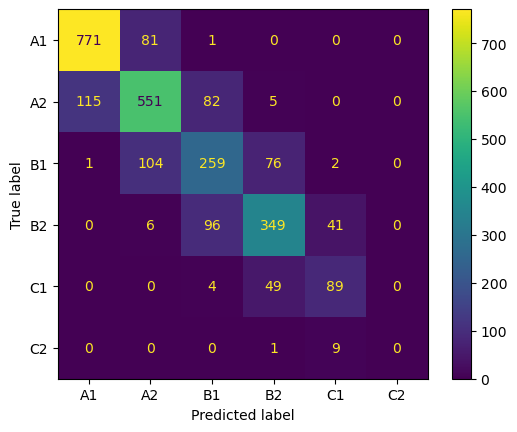

In [29]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = test['predictions']

y_true = test['level']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

# Generate accuracy report
unique_labels = set(y_true_mapped)  # Get unique labels

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)
print('\nClassification Report:')
print(class_report)
table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        # For accuracy, add precision and recall as 0
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train['level'], test['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [30]:
print(f'Ended prediction at {datetime.datetime.now()}')
wandb.finish()

Ended prediction at 2024-08-18 08:19:42.914715


eval/accuracy,▁█
eval/balanced_accuracy,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,▁▁
train/epoch,▁▂▃▄▄▅▆▇███
train/global_step,▁▂▃▄▄▅▆▇█████
train/grad_norm,█▄▇▂▁▂▁▄
train/learning_rate,█▇▆▅▄▃▂▁
train/loss,█▄▃▃▂▁▁▁
